In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from generalization.randomization import available_corruptions

import matplotlib.pyplot as plt
import numpy as np
import os

def get_num_cpus():
    return len(os.sched_getaffinity(0))


def check(learn, dl, plt_title=None):
    y_pred, ys, losses = learn.get_preds(1, dl=dl, with_loss=True, reorder=True)

    print(y_pred[0].min(), y_pred[0].max(), y_pred[0].sum())
    print(y_pred[0].argmax(), ys[0], losses[0])
    plot_losses(losses, width=1, plt_title=plt_title)


def plot_losses(losses, width=1, plt_title=None):
    plt.bar(np.arange(len(losses)), losses, width=width)
    plt.title(plt_title)
    plt.show()


print("Available corruptions:\n", available_corruptions())

Available corruptions:
 ['gaussian_pixels', 'random_labels', 'random_pixels', 'partial_labels', 'shuffled_pixels']


## Configuration for all experiments

In [5]:
from generalization.randomization import build_cifar10
import torch


def build_experiments(corrupt_prob, corrupt_name=None, batch_size=128):
    corruptions = available_corruptions()

    experiments = dict()

    if corrupt_name is not None:
        corruptions = [corrupt_name]

    for corrupt_name in corruptions:
        if corrupt_name == "gaussian_pixels":
            continue
        train_set, test_set = build_cifar10(
            corruption_name=corrupt_name,
            corruption_prob=corrupt_prob,
            show_images=False,
            verbose=False,
        )

        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=get_num_cpus(),
            pin_memory=True,
        )

        val_set, test_set = torch.utils.data.random_split(
            test_set, [len(test_set) // 2, len(test_set) - len(test_set) // 2]
        )

        val_loader = torch.utils.data.DataLoader(
            val_set,
            batch_size=batch_size * 2,
            shuffle=False,
            num_workers=get_num_cpus(),
            pin_memory=True,
        )

        test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=batch_size * 2,
            shuffle=False,
            num_workers=get_num_cpus(),
            pin_memory=True,
        )

        experiments[corrupt_name] = {
            "train_set": train_set,
            "val_set": val_set,
            "test_set": test_set,
            "train_loader": train_loader,
            "val_loader": val_loader,
            "test_loader": test_loader,
        }
    return experiments

## All Corruptions

In [6]:
import lightning as L
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.loggers import TensorBoardLogger

from torch import nn
from torch.nn import functional as F

class LitModel(L.LightningModule):
    def __init__(self, net: nn.Module, lr: float = 1e-3, n_classes=10):
        super().__init__()
        self.net = net
        self.lr = lr
        self.n_classes = n_classes
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
        self.valid_top5_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=n_classes, top_k=5
        )
        self.early_stop_counter = 0
        self.patience = 5
        self.best_valid_acc = 0

    def forward(self, x):
        out = self.net(x)
        return out

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        self.log("train/loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.step_metrics(logits=logits, y=y, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        self.log("valid/loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.step_metrics(logits=logits, y=y, mode="val")
        return loss
    
    def on_validation_end(self) -> None:
        current_valid_acc = self.valid_acc.compute()
        if current_valid_acc > self.best_valid_acc:
            self.best_valid_acc = current_valid_acc
            self.early_stop_counter = 0
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter > self.patience:
                self.early_stop_counter = 0
                # self.trainer.should_stop = True

                self.logger.experiment.add_scalar("early_stop", self.current_epoch)
        

    def step_metrics(self, logits, y, mode):
        if mode == "train":
            self.train_acc.update(logits, y)
            self.log(
                "train/acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True
            )

        elif mode == "val":
            self.valid_acc.update(logits, y)
            self.valid_top5_acc.update(logits, y)

            self.log(
                "valid/acc",
                self.valid_acc.compute(),
                on_step=False,
                on_epoch=True,
                prog_bar=True,
            )
            self.log(
                "valid/top5_acc",
                self.valid_top5_acc.compute(),
                on_step=False,
                on_epoch=True,
                prog_bar=True,
            )

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

In [7]:
import time
from generalization.models import get_cifar_models

torch.set_float32_matmul_precision("medium")

SEED = 5678
BATCH_SIZE = 256
LEARNING_RATE = 0.01
PRINT_EVERY = 3
EPOCHS = 10
MODEL_NAME = "inception"
CORRUPT_NAME = "random_labels"

L.seed_everything(SEED)
experiments = build_experiments(corrupt_prob=0.1, corrupt_name=CORRUPT_NAME, batch_size=BATCH_SIZE)

models = get_cifar_models(lib="torch")
print(models.keys())
net = models.get(MODEL_NAME)

logger = None
# logger = WandbLogger(
#     name=f"{model}",
#     project="generalization",
#     log_model=True,
#     save_dir="logs",
#     group=f"{corruption}"
# )

logger = TensorBoardLogger(
    save_dir="logs",
    name=f"{MODEL_NAME}",
    version=f"{CORRUPT_NAME}",
)

Global seed set to 5678


Files already downloaded and verified


/home/step/Code/projects/ids-generalization/notebooks/generalization/randomization/dataset.py:203: UserWarning: corruption_prob is ignored when corruption_name is 'random_*'
  warnings.warn(


Files already downloaded and verified
dict_keys(['alexnet', 'inception', 'mlp_1x512', 'mlp_3x512'])


In [6]:
trainer = L.Trainer(
    max_epochs=60, 
    logger=logger , 
    default_root_dir="logs",
)
pl_model = LitModel(net, lr=LEARNING_RATE, n_classes=10)
start_time = time.time()
trainer.fit(
    pl_model,
    experiments[CORRUPT_NAME]["train_loader"],
    experiments[CORRUPT_NAME]["val_loader"],
)
print(f"Training took {time.time() - start_time:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | net            | InceptionSmall     | 8.0 M 
1 | train_acc      | MulticlassAccuracy | 0     
2 | valid_acc      | MulticlassAccuracy | 0     
3 | valid_top5_acc | MulticlassAccuracy | 0     
------------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.191    Total estimated model params size (MB)


Epoch 11:   0%|          | 0/196 [00:00<?, ?it/s, v_num=bels, valid/loss=18.10, valid/acc=0.0939, valid/top5_acc=0.443, train/loss=0.0805, train/acc=0.972]          

Epoch 11:  18%|█▊        | 35/196 [00:02<00:10, 15.51it/s, v_num=bels, valid/loss=18.10, valid/acc=0.0939, valid/top5_acc=0.443, train/loss=0.0805, train/acc=0.972]

In [1]:
!tensorboard --logdir logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


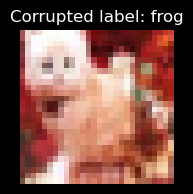

In [91]:
from torchvision import transforms
from generalization.randomization.utils import CIFAR10_NORMALIZE_MEAN, CIFAR10_NORMALIZE_STD


idx = np.random.randint(len(experiments[CORRUPT_NAME]["train_set"]))

unnormalize = transforms.functional.normalize(
    experiments[CORRUPT_NAME]["train_set"][idx][0],
    mean=[-m / s for m, s in zip(CIFAR10_NORMALIZE_MEAN, CIFAR10_NORMALIZE_STD)],
    std=[1 / s for s in CIFAR10_NORMALIZE_STD],
)

label = experiments[CORRUPT_NAME]["train_set"][idx][1]
class_name = experiments[CORRUPT_NAME]["train_set"].classes[label]


f, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(unnormalize.permute(1, 2, 0))
ax.set_title(f"Corrupted label: {class_name}")
ax.axis("off")
plt.show()

In [ ]:
# import wandb
# 
# for model in models.keys():
#     print("Model:", model)

#     for corruption, exp in experiments.items():
#         wandb.finish()
#         print("Corruption:", corruption)

#         net = models.get(model)
#         logger = WandbLogger(
#             name=f"{model}",
#             project="generalization",
#             log_model=True,
#             save_dir="logs",
#             group=f"{corruption}"
#         )
#         trainer = L.Trainer(max_epochs=10, logger=logger, default_root_dir="logs")
#         pl_model = LitModel(net)
#         start_time = time.time()
#         trainer.fit(
#             pl_model,
#             experiments[corruption]["train_loader"],
#             experiments[corruption]["test_loader"],
#         )
#         print(
#             f"== Total time: {time.time() - start_time:.3f} s, {(time.time() - start_time)/ 60:.3f} min"
#         )
#         break